### EDA on textual columns

The following notebook outlines exploratory data analysis done on the textual columns on the fraudulent job dataset.

In [2]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import textstat
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Anders_1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the dataset and carry out some statistical eda on overall dataset before diving into textual columns

In [3]:
dataset = pd.read_csv('../data/fake_job_postings.csv')
display(dataset.head())
# check the dimensions of the dataset
print(dataset.shape)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


(17880, 18)


Overall stats for null values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64
job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
req

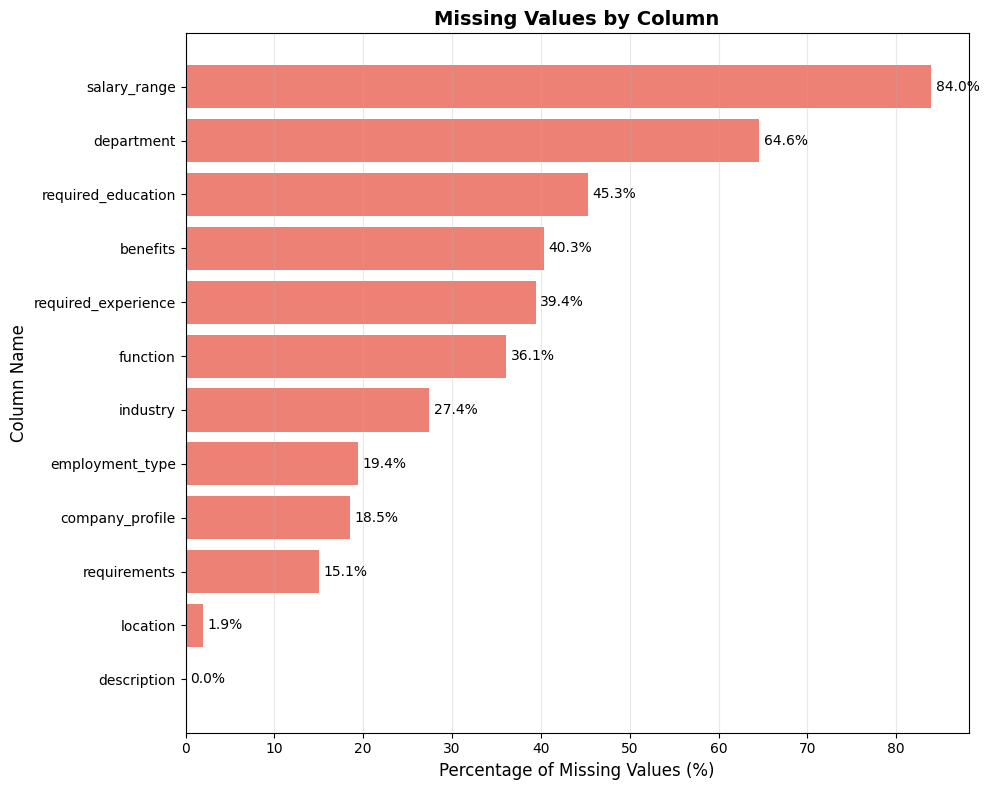

In [4]:
# check for null values
null_counts = dataset.isnull().sum()
print(null_counts)

# get percentage of null values for each column
null_percentage = dataset.isnull().sum() / len(dataset) * 100
print(null_percentage)

# create plot for null values
plt.figure(figsize=(10, 8))
null_data = null_percentage[null_percentage > 0].sort_values(ascending=True)
bars = plt.barh(null_data.index, null_data.values, color='#e74c3c', alpha=0.7)
plt.xlabel('Percentage of Missing Values (%)', fontsize=12)
plt.ylabel('Column Name', fontsize=12)
plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# add percentage labels
for i, (index, value) in enumerate(null_data.items()):
    plt.text(value + 0.5, i, f'{value:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Check for duplicated rows before proceeding

In [5]:
print(dataset.duplicated().sum())

0


Check class imbalance

fraudulent
0    17014
1      866
Name: count, dtype: int64
fraudulent
0    95.1566
1     4.8434
Name: count, dtype: float64


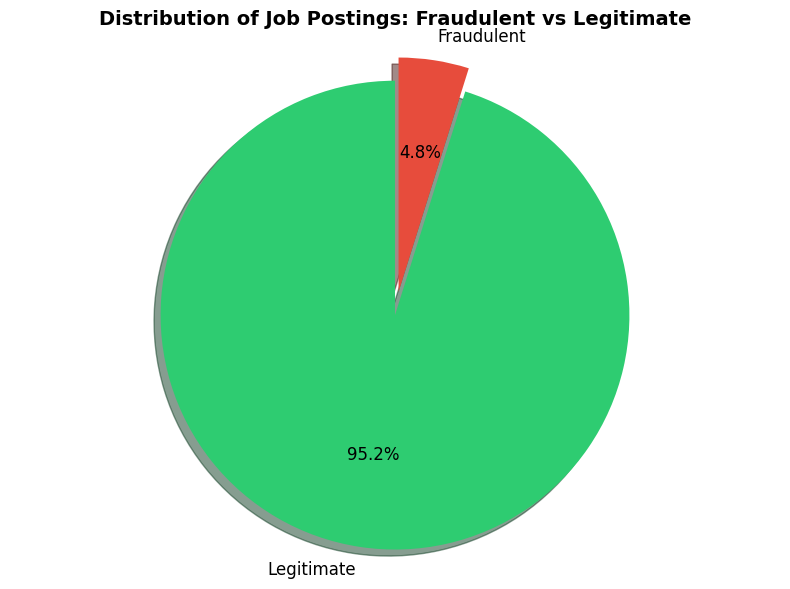

In [6]:
print(dataset['fraudulent'].value_counts())
# check for class imbalance percentage
print(dataset['fraudulent'].value_counts() / len(dataset) * 100)

# create pie chart for visualisation
fraud_counts = dataset['fraudulent'].value_counts()
labels = ['Legitimate', 'Fraudulent']
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # explode the fraudulent slice

plt.figure(figsize=(8, 6))
plt.pie(fraud_counts, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode, shadow=True, textprops={'fontsize': 12})
plt.title('Distribution of Job Postings: Fraudulent vs Legitimate', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Title column

In [7]:
# check to see of we should treat is a categorical column
print(dataset['title'].nunique())

11231


Fraudulent jobs - title length mean: 30.666281755196305
Non-fraudulent jobs - title length mean: 28.42159398142706


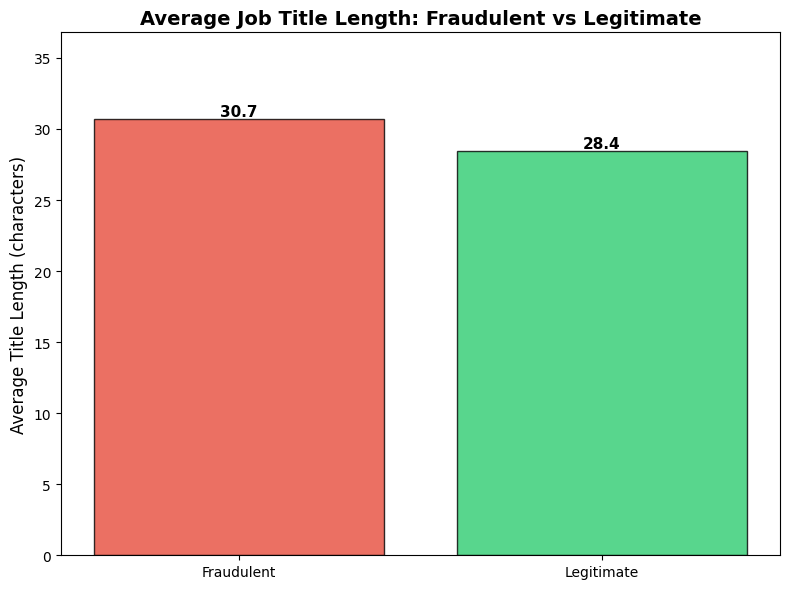

In [8]:
# find mean length for fraudulent vs non-fraudulent
dataset['title_len'] = dataset['title'].apply(len)
print("Fraudulent jobs - title length mean:", dataset[dataset['fraudulent'] == 1]['title_len'].mean())
print("Non-fraudulent jobs - title length mean:", dataset[dataset['fraudulent'] == 0]['title_len'].mean())

# create bar chart comparing title lengths
fraud_title_len = dataset[dataset['fraudulent'] == 1]['title_len'].mean()
legit_title_len = dataset[dataset['fraudulent'] == 0]['title_len'].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(['Fraudulent', 'Legitimate'], [fraud_title_len, legit_title_len], 
               color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
plt.ylabel('Average Title Length (characters)', fontsize=12)
plt.title('Average Job Title Length: Fraudulent vs Legitimate', fontsize=14, fontweight='bold')
plt.ylim(0, max(fraud_title_len, legit_title_len) * 1.2)

# add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# find distinct non-alphanumeric characters in title
title_non_alphanumeric_chars = set()

for title in dataset['title'].fillna(''):
    for char in title:
        if not char.isalnum() and not char.isspace():
            title_non_alphanumeric_chars.add(char)

print(f"Distinct non-alphanumeric characters in title column: {sorted(title_non_alphanumeric_chars)}")
print(f"Total count: {len(title_non_alphanumeric_chars)}")

Distinct non-alphanumeric characters in title column: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', '?', '@', '[', '\\', ']', '_', '|', '~']
Total count: 24


Description column

Fraudulent jobs - description word count mean: 158.74826789838338
Fraudulent jobs - description word count median: 113.5
Fraudulent jobs - description word count std: 136.63300967283297
Non-fraudulent jobs - description word count mean: 171.04137768896203
Non-fraudulent jobs - description word count median: 147.0
Non-fraudulent jobs - description word count std: 122.5616332992522


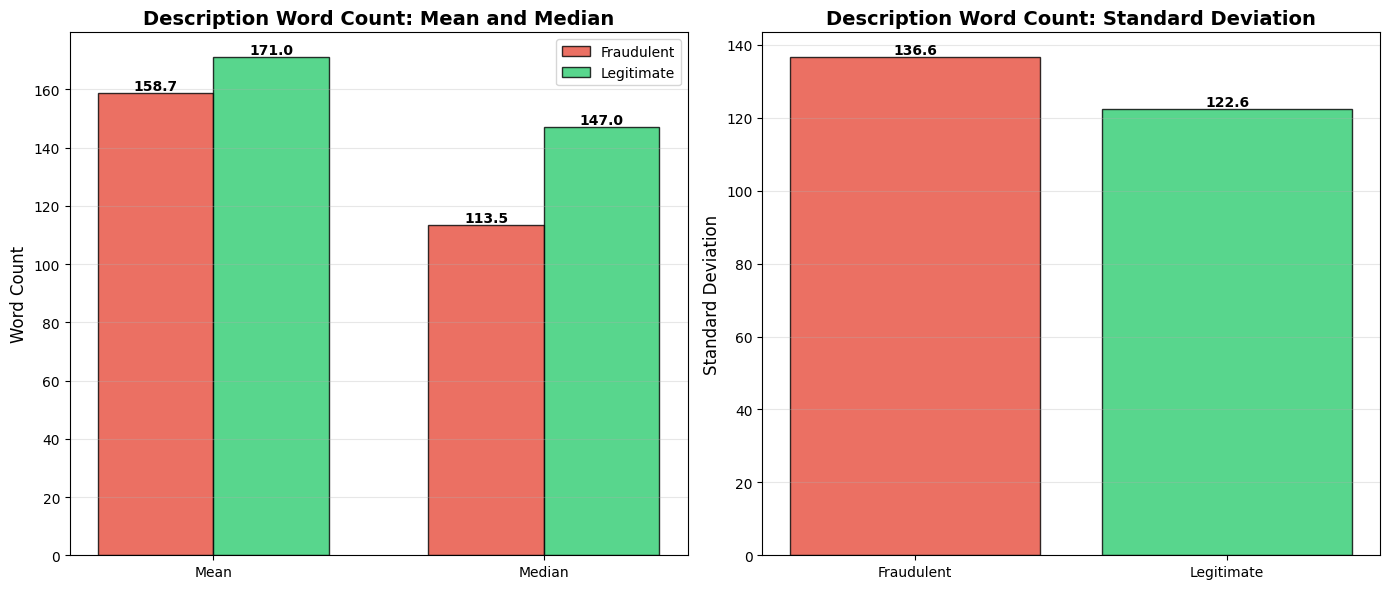

In [9]:
# find the number of words in description and get the average, median, and standard deviation for fraudulent and non-fraudulent jobs
dataset['description_word_count'] = dataset['description'].fillna('').apply(lambda x: len(x.split()))

fraud_stats = {
    'mean': dataset[dataset['fraudulent'] == 1]['description_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 1]['description_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 1]['description_word_count'].std()
}

legit_stats = {
    'mean': dataset[dataset['fraudulent'] == 0]['description_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 0]['description_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 0]['description_word_count'].std()
}

print("Fraudulent jobs - description word count mean:", fraud_stats['mean'])
print("Fraudulent jobs - description word count median:", fraud_stats['median'])
print("Fraudulent jobs - description word count std:", fraud_stats['std'])
print("Non-fraudulent jobs - description word count mean:", legit_stats['mean'])
print("Non-fraudulent jobs - description word count median:", legit_stats['median'])
print("Non-fraudulent jobs - description word count std:", legit_stats['std'])

# create visualisation comparing description word counts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# bar chart for mean and median
metrics = ['Mean', 'Median']
fraud_values = [fraud_stats['mean'], fraud_stats['median']]
legit_values = [legit_stats['mean'], legit_stats['median']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, fraud_values, width, label='Fraudulent', 
                    color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, legit_values, width, label='Legitimate', 
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Word Count', fontsize=12)
axes[0].set_title('Description Word Count: Mean and Median', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.1f}',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

# bar chart for standard deviation
categories = ['Fraudulent', 'Legitimate']
std_values = [fraud_stats['std'], legit_stats['std']]

bars = axes[1].bar(categories, std_values, 
                   color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Standard Deviation', fontsize=12)
axes[1].set_title('Description Word Count: Standard Deviation', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

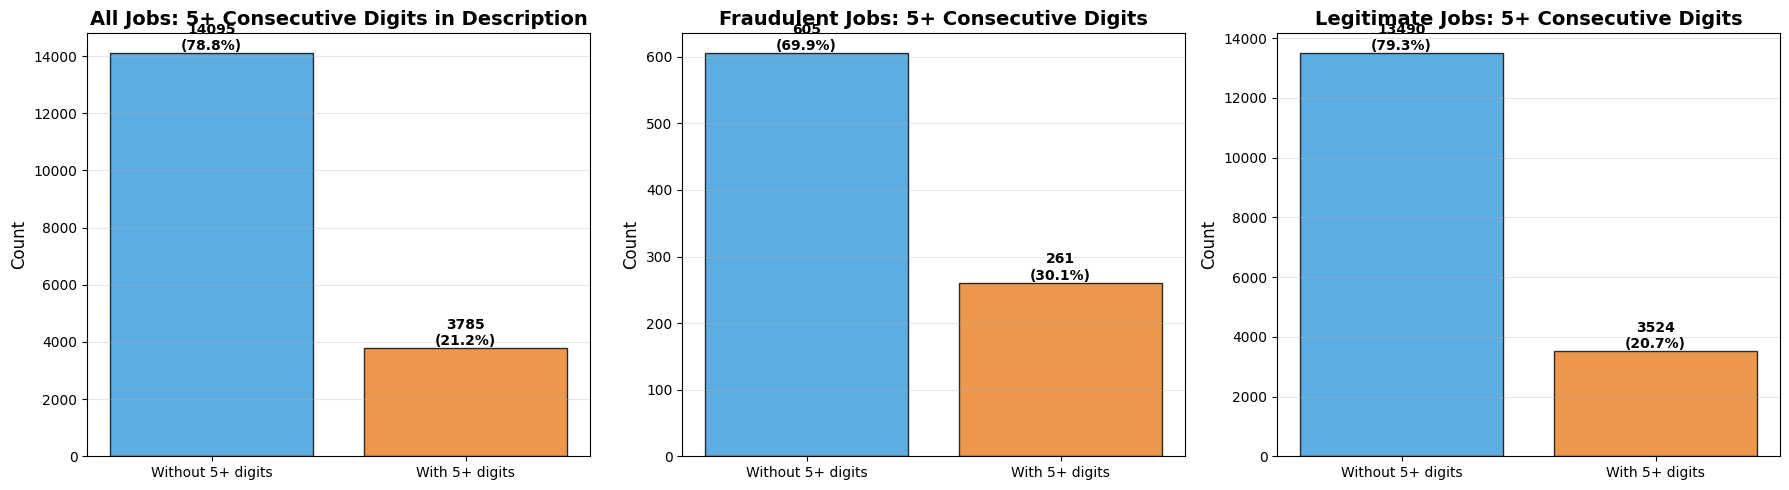

Jobs with 5+ consecutive digits in description:
has_5_consecutive_digits
False    14095
True      3785
Name: count, dtype: int64 

has_5_consecutive_digits
False    78.831096
True     21.168904
Name: proportion, dtype: float64 


Fraudulent jobs with 5+ consecutive digits:
has_5_consecutive_digits
False    605
True     261
Name: count, dtype: int64 

has_5_consecutive_digits
False    69.861432
True     30.138568
Name: proportion, dtype: float64 


Non-fraudulent jobs with 5+ consecutive digits:
has_5_consecutive_digits
False    13490
True      3524
Name: count, dtype: int64 

has_5_consecutive_digits
False    79.287645
True     20.712355
Name: proportion, dtype: float64 



In [10]:
# check if description column contains 5 or more consecutive digits
dataset['has_5_consecutive_digits'] = dataset['description'].fillna('').apply(lambda x: bool(re.search(r'\d{5,}', x)))

# calculate statistics
overall_counts = dataset['has_5_consecutive_digits'].value_counts()
overall_pct = dataset['has_5_consecutive_digits'].value_counts(normalize=True) * 100

fraud_counts = dataset[dataset['fraudulent'] == 1]['has_5_consecutive_digits'].value_counts()
fraud_pct = dataset[dataset['fraudulent'] == 1]['has_5_consecutive_digits'].value_counts(normalize=True) * 100

legit_counts = dataset[dataset['fraudulent'] == 0]['has_5_consecutive_digits'].value_counts()
legit_pct = dataset[dataset['fraudulent'] == 0]['has_5_consecutive_digits'].value_counts(normalize=True) * 100

# create visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# overall distribution
categories = ['Without 5+ digits', 'With 5+ digits']
values = [overall_counts.get(False, 0), overall_counts.get(True, 0)]
colors = ['#3498db', '#e67e22']

bars = axes[0].bar(categories, values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('All Jobs: 5+ Consecutive Digits in Description', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar, val, pct in zip(bars, values, [overall_pct.get(False, 0), overall_pct.get(True, 0)]):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{val}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# fraudulent jobs
fraud_values = [fraud_counts.get(False, 0), fraud_counts.get(True, 0)]
bars = axes[1].bar(categories, fraud_values, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Fraudulent Jobs: 5+ Consecutive Digits', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar, val, pct in zip(bars, fraud_values, [fraud_pct.get(False, 0), fraud_pct.get(True, 0)]):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{val}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# legitimate jobs
legit_values = [legit_counts.get(False, 0), legit_counts.get(True, 0)]
bars = axes[2].bar(categories, legit_values, color=colors, alpha=0.8, edgecolor='black')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Legitimate Jobs: 5+ Consecutive Digits', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

for bar, val, pct in zip(bars, legit_values, [legit_pct.get(False, 0), legit_pct.get(True, 0)]):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{val}\n({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# summary stats
print("Jobs with 5+ consecutive digits in description:")
print(overall_counts, "\n")
print(overall_pct, "\n")
print("\nFraudulent jobs with 5+ consecutive digits:")
print(fraud_counts, "\n")
print(fraud_pct, "\n")
print("\nNon-fraudulent jobs with 5+ consecutive digits:")
print(legit_counts, "\n")
print(legit_pct, "\n")

In [24]:
# get top 25 professional words from non-fraudulent job descriptions
stop_words = set(stopwords.words('english'))

# filter for non-fraudulent jobs
non_fraud_descriptions = dataset[dataset['fraudulent'] == 0]['description'].fillna('')

# tokenize and count words
all_words = []
for desc in non_fraud_descriptions:
    # convert to lowercase and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', desc.lower())
    # filter out stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    all_words.extend(words)

# get top 25 most common words
word_counts = Counter(all_words)
top_50_words = word_counts.most_common(50)

print("Top 50 professional words in non-fraudulent job descriptions:")
for word, count in top_50_words:
    print(f"{word}: {count}")


Top 50 professional words in non-fraudulent job descriptions:
team: 18257
work: 14422
business: 10474
experience: 9956
company: 9706
new: 9451
customer: 9428
sales: 9327
looking: 8346
development: 7967
management: 7361
product: 7212
marketing: 6761
service: 6751
support: 6304
amp: 6216
design: 6041
client: 6024
services: 5923
time: 5854
working: 5826
job: 5781
data: 5718
position: 5676
clients: 5461
customers: 5453
role: 5210
skills: 5038
based: 4846
including: 4620
software: 4603
provide: 4578
project: 4497
help: 4383
products: 4342
quality: 4311
high: 4309
ensure: 4207
well: 4191
opportunity: 4189
responsible: 4150
web: 4114
responsibilities: 4086
people: 3953
manager: 3876
part: 3868
develop: 3866
technical: 3785
growing: 3747
solutions: 3736


In [25]:
# filter for fraudulent jobs
fraud_descriptions = dataset[dataset['fraudulent'] == 1]['description'].fillna('')

# tokenize and count words
all_words = []
for desc in fraud_descriptions:
    # convert to lowercase and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', desc.lower())
    # filter out stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    all_words.extend(words)

# get top 50 most common words
word_counts = Counter(all_words)
top_50_words = word_counts.most_common(50)

print("Top 50 professional words in fraudulent job descriptions:")
for word, count in top_50_words:
    print(f"{word}: {count}")


Top 50 professional words in fraudulent job descriptions:
work: 1052
amp: 695
team: 522
experience: 496
company: 491
time: 489
position: 477
management: 464
project: 454
customer: 453
service: 449
business: 448
looking: 434
skills: 426
support: 384
engineering: 371
services: 350
solutions: 340
data: 335
job: 330
new: 325
within: 323
equipment: 317
product: 315
provide: 303
systems: 301
products: 294
quality: 291
people: 288
required: 287
ensure: 278
information: 275
manager: 273
full: 263
process: 261
responsibilities: 251
industry: 249
development: 249
customers: 247
including: 242
responsible: 240
design: 240
technical: 234
per: 233
duties: 232
must: 231
sales: 226
perform: 213
requirements: 212
maintenance: 209


In [26]:
# filter for non-fraudulent jobs
non_fraud_descriptions = dataset[dataset['fraudulent'] == 0]['description'].fillna('')

# tokenize and count words for non-fraudulent jobs
non_fraud_words = []
for desc in non_fraud_descriptions:
    # convert to lowercase and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', desc.lower())
    # filter out stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    non_fraud_words.extend(words)

# get word counts for non-fraudulent jobs
non_fraud_word_counts = Counter(non_fraud_words)

# filter for fraudulent jobs
fraud_descriptions = dataset[dataset['fraudulent'] == 1]['description'].fillna('')

# tokenize and count words for fraudulent jobs
fraud_words = []
for desc in fraud_descriptions:
    # convert to lowercase and split into words
    words = re.findall(r'\b[a-zA-Z]+\b', desc.lower())
    # filter out stop words and short words
    words = [word for word in words if word not in stop_words and len(word) > 2]
    fraud_words.extend(words)

# get word counts for fraudulent jobs
fraud_word_counts = Counter(fraud_words)

# get all words that appear in fraudulent jobs
fraud_words_set = set(fraud_word_counts.keys())

# find top 50 words in non-fraudulent jobs that are NOT in fraudulent jobs at all
unique_non_fraud_words = []
for word, count in non_fraud_word_counts.most_common():
    if word not in fraud_words_set:
        unique_non_fraud_words.append((word, count))
    if len(unique_non_fraud_words) == 50:
        break

print("Top 50 words in non-fraudulent jobs that are NOT in fraudulent jobs:")
for word, count in unique_non_fraud_words:
    print(f"{word}: {count}")

Top 50 words in non-fraudulent jobs that are NOT in fraudulent jobs:
asia: 795
tidewater: 693
reimbursedexcellent: 626
adkins: 617
cardsgabriel: 615
redirect: 588
awesome: 533
airfare: 478
game: 367
servers: 365
fails: 365
fragrance: 342
vend: 335
startups: 324
dealer: 305
intern: 302
attitudedemonstrate: 271
nvq: 269
environmentconsistently: 259
ding: 255
got: 254
instructional: 253
providedairfare: 252
beach: 251
athens: 250
conversion: 249
een: 243
het: 239
managermaintain: 238
berlin: 237
disabilities: 232
premises: 231
greece: 229
detailparticipate: 228
procedurestake: 227
recently: 226
shyp: 226
pickup: 225
neededmaintain: 225
european: 225
guidelinesadhere: 223
clinic: 223
keen: 222
founders: 222
marketinvoice: 221
ucp: 213
turn: 212
metering: 211
twice: 211
esri: 210


In [27]:
SCAMMY_PHRASES = [
    'urgent', 'guaranteed', 'money', 'cash', 'quick cash', 'investment', 'upfront fee', 'wire transfer',
    'limited time', 'winner', 'prize', 'bonus', 'earn', 'easy money', 'no experience', 'click here',
    'apply fast', 'instant', 'payable immediately', 'work from home', 'sms us', 'act now', 'free',
    'risk free', 'no risk', 'make money fast', 'earn extra income', 'financial freedom', 'be your own boss',
    'unlimited earning', 'passive income', 'get paid', 'weekly pay', 'daily pay', 'commission',
    'multi level marketing', 'mlm', 'pyramid', 'recruitment', 'sign up fee', 'registration fee',
    'processing fee', 'training fee', 'starter kit', 'pay to apply', 'credit card required',
    'bank account', 'personal information', 'social security', 'copy and paste', 'no selling',
    'no interview', 'hired immediately', 'start today', 'start immediately', 'too good to be true'
]

# filter for fraudulent jobs
fraud_data = dataset[dataset['fraudulent'] == 1]

# search for scammy phrases in fraudulent job descriptions
phrase_counts = {}
for phrase in SCAMMY_PHRASES:
    # count rows where the phrase appears in description (case-insensitive)
    count = fraud_data['description'].fillna('').str.lower().str.contains(phrase, regex=False).sum()
    phrase_counts[phrase] = count

print(f"Total fraudulent jobs: {len(fraud_data)}")
print("\nScammy phrases found in fraudulent job descriptions:")
for phrase, count in sorted(phrase_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(fraud_data) * 100) if len(fraud_data) > 0 else 0
    print(f"{phrase}: {count} rows ({percentage:.1f}%)")

Total fraudulent jobs: 866

Scammy phrases found in fraudulent job descriptions:
earn: 226 rows (26.1%)
free: 75 rows (8.7%)
work from home: 62 rows (7.2%)
money: 60 rows (6.9%)
cash: 60 rows (6.9%)
no experience: 40 rows (4.6%)
bonus: 34 rows (3.9%)
urgent: 33 rows (3.8%)
get paid: 32 rows (3.7%)
commission: 23 rows (2.7%)
click here: 21 rows (2.4%)
start immediately: 20 rows (2.3%)
investment: 14 rows (1.6%)
weekly pay: 14 rows (1.6%)
be your own boss: 12 rows (1.4%)
guaranteed: 10 rows (1.2%)
recruitment: 10 rows (1.2%)
instant: 7 rows (0.8%)
mlm: 3 rows (0.3%)
daily pay: 1 rows (0.1%)
registration fee: 1 rows (0.1%)
bank account: 1 rows (0.1%)
social security: 1 rows (0.1%)
no selling: 1 rows (0.1%)
start today: 1 rows (0.1%)
quick cash: 0 rows (0.0%)
upfront fee: 0 rows (0.0%)
wire transfer: 0 rows (0.0%)
limited time: 0 rows (0.0%)
winner: 0 rows (0.0%)
prize: 0 rows (0.0%)
easy money: 0 rows (0.0%)
apply fast: 0 rows (0.0%)
payable immediately: 0 rows (0.0%)
sms us: 0 rows (0.0%

In [28]:
# find distinct non-alphanumeric characters in description columns
description_non_alphanumeric_chars = set()

for description in dataset['description'].fillna(''):
    for char in description:
        if not char.isalnum() and not char.isspace():
            description_non_alphanumeric_chars.add(char)

print(f"\nDistinct non-alphanumeric characters in description column: {sorted(description_non_alphanumeric_chars)}")
print(f"Total count: {len(description_non_alphanumeric_chars)}")


Distinct non-alphanumeric characters in description column: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\x92', '\x96', '\x9f', '¢', '£', '§', '¨', '©', '«', '\xad', '®', '°', '´', '·', '»', '×', '˚', '̈', '΄', 'ั', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', '็', '่', '้', '์', '\u200b', '\u200e', '‐', '‑', '‒', '–', '—', '―', '‘', '’', '“', '”', '„', '•', '‣', '…', '\u202a', '″', '€', '№', '™', '∙', '▪', '►', '◄', '○', '●', '◦', '✦', '、', '。', '・', '\uf09f', '\uf0a7', '\uf0b7', '\uf0fc', '！', '）', '，', '￼', '�', '\U00100083']
Total count: 102


In [29]:
# calculate Flesch Reading Ease scores for all descriptions
dataset['readability_score'] = dataset['description'].fillna('').apply(lambda x: textstat.flesch_reading_ease(x) if x else None)

# Get mean readability scores for fraudulent and non-fraudulent jobs
fraud_readability = dataset[dataset['fraudulent'] == 1]['readability_score'].mean()
non_fraud_readability = dataset[dataset['fraudulent'] == 0]['readability_score'].mean()

print(f"Mean Flesch Reading Ease score for fraudulent jobs: {fraud_readability:.2f}")
print(f"Mean Flesch Reading Ease score for non-fraudulent jobs: {non_fraud_readability:.2f}")
print(f"\nDifference: {abs(fraud_readability - non_fraud_readability):.2f}")
print("\nNote: Higher scores indicate easier readability (0-100 scale)")

Mean Flesch Reading Ease score for fraudulent jobs: 20.18
Mean Flesch Reading Ease score for non-fraudulent jobs: 20.23

Difference: 0.04

Note: Higher scores indicate easier readability (0-100 scale)


Benefits column

Fraudulent jobs - benefits word count mean: 29.451501154734412
Fraudulent jobs - benefits word count median: 5.0
Fraudulent jobs - benefits word count std: 53.44437401028162
Non-fraudulent jobs - benefits word count mean: 30.018337839426355
Non-fraudulent jobs - benefits word count median: 6.0
Non-fraudulent jobs - benefits word count std: 49.56222760703978


/var/folders/ks/1vwfb61d70zg88p9htntfxlw0000gn/T/ipykernel_46110/818022102.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Fraudulent', 'Non-fraudulent'], patch_artist=True)


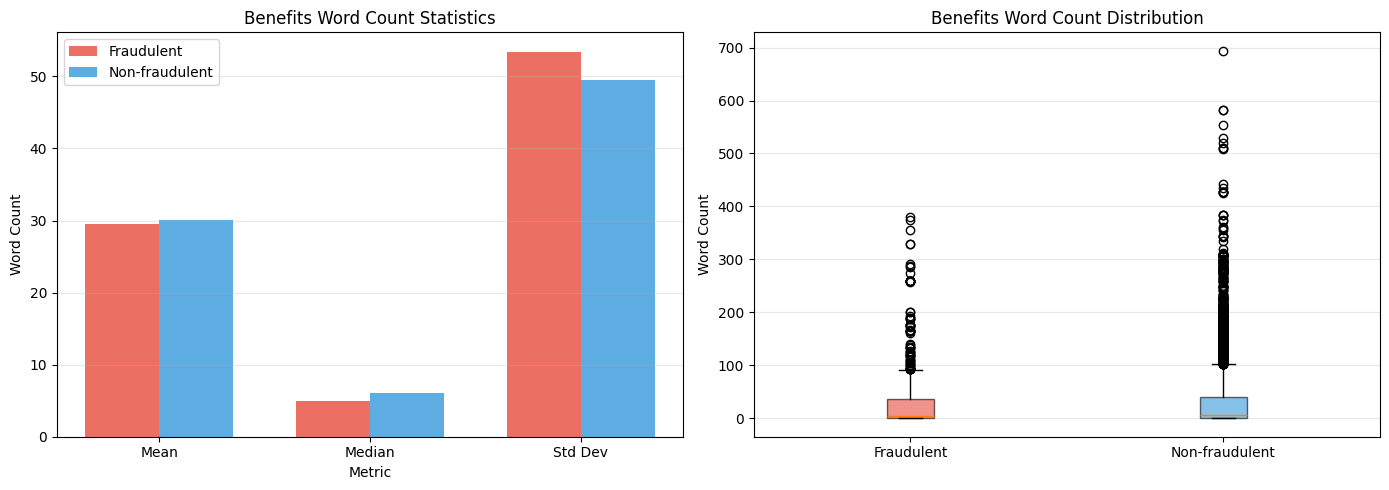

In [11]:
# find the number of words in benefits and get the average, median, and standard deviation for fraudulent and non-fraudulent jobs
dataset['benefits_word_count'] = dataset['benefits'].fillna('').apply(lambda x: len(x.split()))

# calculate stats
fraud_stats = {
    'mean': dataset[dataset['fraudulent'] == 1]['benefits_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 1]['benefits_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 1]['benefits_word_count'].std()
}

non_fraud_stats = {
    'mean': dataset[dataset['fraudulent'] == 0]['benefits_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 0]['benefits_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 0]['benefits_word_count'].std()
}

print("Fraudulent jobs - benefits word count mean:", fraud_stats['mean'])
print("Fraudulent jobs - benefits word count median:", fraud_stats['median'])
print("Fraudulent jobs - benefits word count std:", fraud_stats['std'])
print("Non-fraudulent jobs - benefits word count mean:", non_fraud_stats['mean'])
print("Non-fraudulent jobs - benefits word count median:", non_fraud_stats['median'])
print("Non-fraudulent jobs - benefits word count std:", non_fraud_stats['std'])

# create visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart comparing mean, median, std
metrics = ['Mean', 'Median', 'Std Dev']
fraud_values = [fraud_stats['mean'], fraud_stats['median'], fraud_stats['std']]
non_fraud_values = [non_fraud_stats['mean'], non_fraud_stats['median'], non_fraud_stats['std']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, fraud_values, width, label='Fraudulent', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width/2, non_fraud_values, width, label='Non-fraudulent', color='#3498db', alpha=0.8)
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Word Count')
axes[0].set_title('Benefits Word Count Statistics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# box plot comparing distributions
fraud_benefits = dataset[dataset['fraudulent'] == 1]['benefits_word_count']
non_fraud_benefits = dataset[dataset['fraudulent'] == 0]['benefits_word_count']

box_data = [fraud_benefits, non_fraud_benefits]
bp = axes[1].boxplot(box_data, labels=['Fraudulent', 'Non-fraudulent'], patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#3498db')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('Word Count')
axes[1].set_title('Benefits Word Count Distribution')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Company profile column

Fraudulent jobs - company_profile word count mean: 31.709006928406467
Fraudulent jobs - company_profile word count median: 0.0
Fraudulent jobs - company_profile word count std: 52.46810944161063
Non-fraudulent jobs - company_profile word count mean: 95.65052309862466
Non-fraudulent jobs - company_profile word count median: 86.0
Non-fraudulent jobs - company_profile word count std: 85.68588088030516


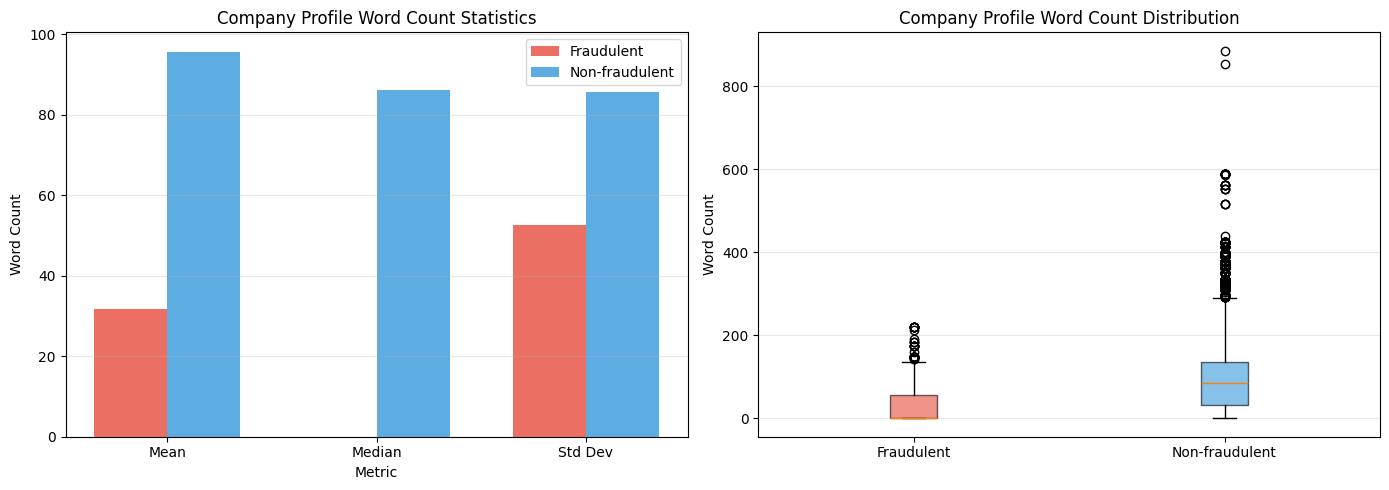

In [12]:
# find the number of words in company_profile and get the average, median, and standard deviation for fraudulent and non-fraudulent jobs
dataset['company_profile_word_count'] = dataset['company_profile'].fillna('').apply(lambda x: len(x.split()))

# calculate stats
fraud_stats = {
    'mean': dataset[dataset['fraudulent'] == 1]['company_profile_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 1]['company_profile_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 1]['company_profile_word_count'].std()
}

non_fraud_stats = {
    'mean': dataset[dataset['fraudulent'] == 0]['company_profile_word_count'].mean(),
    'median': dataset[dataset['fraudulent'] == 0]['company_profile_word_count'].median(),
    'std': dataset[dataset['fraudulent'] == 0]['company_profile_word_count'].std()
}

print("Fraudulent jobs - company_profile word count mean:", fraud_stats['mean'])
print("Fraudulent jobs - company_profile word count median:", fraud_stats['median'])
print("Fraudulent jobs - company_profile word count std:", fraud_stats['std'])
print("Non-fraudulent jobs - company_profile word count mean:", non_fraud_stats['mean'])
print("Non-fraudulent jobs - company_profile word count median:", non_fraud_stats['median'])
print("Non-fraudulent jobs - company_profile word count std:", non_fraud_stats['std'])

# create visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart comparing mean, median, std
metrics = ['Mean', 'Median', 'Std Dev']
fraud_values = [fraud_stats['mean'], fraud_stats['median'], fraud_stats['std']]
non_fraud_values = [non_fraud_stats['mean'], non_fraud_stats['median'], non_fraud_stats['std']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, fraud_values, width, label='Fraudulent', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width/2, non_fraud_values, width, label='Non-fraudulent', color='#3498db', alpha=0.8)
axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Word Count')
axes[0].set_title('Company Profile Word Count Statistics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# box plot comparing distributions
fraud_company_profile = dataset[dataset['fraudulent'] == 1]['company_profile_word_count']
non_fraud_company_profile = dataset[dataset['fraudulent'] == 0]['company_profile_word_count']

box_data = [fraud_company_profile, non_fraud_company_profile]
bp = axes[1].boxplot(box_data, tick_labels=['Fraudulent', 'Non-fraudulent'], patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#3498db')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('Word Count')
axes[1].set_title('Company Profile Word Count Distribution')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Correlation with fraudulent flag

In [32]:
# create binary indicator columns for presence of various fields
has_salary_range = dataset['salary_range'].notnull().astype(int)
has_company_profile = dataset['company_profile'].notnull().astype(int)
has_requirements = dataset['requirements'].notnull().astype(int)
has_benefits = dataset['benefits'].notnull().astype(int)
has_location = dataset['location'].notnull().astype(int)
has_department = dataset['department'].notnull().astype(int)
has_employment_type = dataset['employment_type'].notnull().astype(int)
has_required_experience = dataset['required_experience'].notnull().astype(int)
has_required_education = dataset['required_education'].notnull().astype(int)
has_industry = dataset['industry'].notnull().astype(int)
has_function = dataset['function'].notnull().astype(int)
has_company_logo = dataset['has_company_logo']
has_questions = dataset['has_questions']

# Create a dataframe with these indicators and the fraudulent flag
correlation_df = pd.DataFrame({
    'has_salary_range': has_salary_range,
    'has_company_profile': has_company_profile,
    'has_requirements': has_requirements,
    'has_benefits': has_benefits,
    'has_location': has_location,
    'has_department': has_department,
    'has_employment_type': has_employment_type,
    'has_required_experience': has_required_experience,
    'has_required_education': has_required_education,
    'has_industry': has_industry,
    'has_function': has_function,
    'has_company_logo': has_company_logo,
    'has_questions': has_questions,
    'fraudulent': dataset['fraudulent']
})

# Calculate correlation with fraudulent flag
print("Correlation with fraudulent flag:")
print(correlation_df.corr()['fraudulent'].sort_values(ascending=False))


Correlation with fraudulent flag:
fraudulent                 1.000000
has_salary_range           0.059696
has_department             0.015398
has_location              -0.004240
has_benefits              -0.007803
has_function              -0.013212
has_requirements          -0.017052
has_industry              -0.021915
has_required_education    -0.030584
has_employment_type       -0.048007
has_required_experience   -0.049865
has_questions             -0.091627
has_company_logo          -0.261971
has_company_profile       -0.286330
Name: fraudulent, dtype: float64
